Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1520 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.
Epoch 1/25
24/24 [==============================] - ETA: 0s - loss: 3.3759 - accuracy: 0.2026

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 209s 9s/step - loss: 3.3759 - accuracy: 0.2026 - val_loss: 2.2936 - val_accuracy: 0.1275
Epoch 2/25
24/24 [==============================] - 73s 3s/step - loss: 2.8377 - accuracy: 0.2572 - val_loss: 2.3650 - val_accuracy: 0.0975
Epoch 3/25
24/24 [==============================] - 75s 3s/step - loss: 2.5839 - accuracy: 0.2993 - val_loss: 2.4045 - val_accuracy: 0.1075
Epoch 4/25
24/24 [==============================] - 75s 3s/step - loss: 2.4638 - accuracy: 0.3204 - val_loss: 2.7112 - val_accuracy: 0.0975
Epoch 5/25
24/24 [==============================] - 78s 3s/step - loss: 2.3622 - accuracy: 0.3237 - val_loss: 2.8206 - val_accuracy: 0.1050
Epoch 6/25
2/2 [==============================] - 2s 574ms/step - loss: 2.2895 - accuracy: 0.1400
Test Accuracy: 0.1400
2/2 [==============================] - 1s 294ms/step
Kappa Score: 0.0444


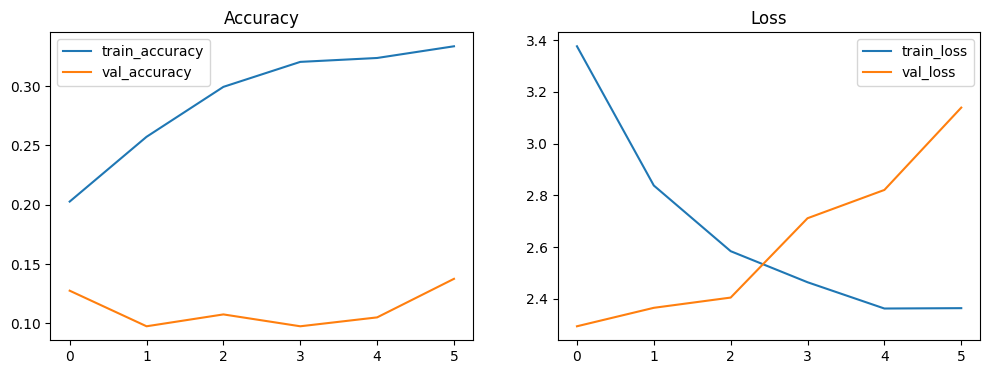

In [ ]:
# Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.model_selection import train_test_split
import pandas as pd

# Set paths
TRAIN_DATASET_PATH = '/content/drive/MyDrive/food-101-tiny/train'
VALID_DATASET_PATH = '/content/drive/MyDrive/food-101-tiny/valid'

# Constants
IMAGE_SIZE = (128, 128)
CLASSES = ['apple_pie', 'bibimbap', 'cannoli', 'edamame', 'falafel', 'french_toast', 'ice_cream', 'ramen', 'sushi', 'tiramisu']

# Data Generators for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET_PATH,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=64
)

# Data Generators for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    VALID_DATASET_PATH,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=64,
    shuffle=False
)

# Split validation data into validation and test sets
val_files, val_labels = valid_generator.filepaths, valid_generator.labels
val_files_train, val_files_test, val_labels_train, val_labels_test = train_test_split(
    val_files, val_labels, test_size=0.2, stratify=val_labels)

# Create data generators for the new validation and test datasets
new_valid_datagen = ImageDataGenerator(rescale=1./255)
new_test_datagen = ImageDataGenerator(rescale=1./255)

new_valid_generator = new_valid_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files_train, 'class': [CLASSES[label] for label in val_labels_train]}),
    directory=VALID_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=64,
    shuffle=True
)

test_generator = new_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files_test, 'class': [CLASSES[label] for label in val_labels_test]}),
    directory=VALID_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=64,
    shuffle=False
)

# Build Model
def build_model(conv_filters, kernel_sizes, dense_units, dropout_rate):
    model = Sequential()
    model.add(Conv2D(conv_filters[0], kernel_sizes[0], activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    for filters, kernel_size in zip(conv_filters[1:], kernel_sizes[1:]):
        model.add(Conv2D(filters, kernel_size, activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(CLASSES), activation='softmax'))

    return model

# Compile and Train Model
def compile_and_train_model(model, optimizer, epochs=25, batch_size=64):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for checkpointing and early stopping
    checkpoint = ModelCheckpoint('/content/drive/MyDrive/model_checkpoint.h5', save_best_only=True, monitor='val_loss')
    csv_logger = CSVLogger('/content/drive/MyDrive/training_log.csv', append=True)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=new_valid_generator,
        callbacks=[checkpoint, csv_logger, early_stopping]
    )
    return history

# Train with modified hyperparameters
model = build_model([32, 64, 128], [(3, 3), (3, 3), (3, 3)], 512, 0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
history = compile_and_train_model(model, optimizer, epochs=25, batch_size=64)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate Kappa value
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f'Kappa Score: {kappa:.4f}')

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1520 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.
Epoch 1/25
48/48 [==============================] - ETA: 0s - loss: 3.3477 - accuracy: 0.1974

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 83s 2s/step - loss: 3.3477 - accuracy: 0.1974 - val_loss: 2.3670 - val_accuracy: 0.1025
Epoch 2/25
48/48 [==============================] - 78s 2s/step - loss: 3.0436 - accuracy: 0.2368 - val_loss: 2.5576 - val_accuracy: 0.0975
Epoch 3/25
48/48 [==============================] - 76s 2s/step - loss: 2.9041 - accuracy: 0.2500 - val_loss: 3.2893 - val_accuracy: 0.1000
Epoch 4/25
48/48 [==============================] - 78s 2s/step - loss: 2.7604 - accuracy: 0.2684 - val_loss: 3.0908 - val_accuracy: 0.1400
Epoch 5/25
48/48 [==============================] - 78s 2s/step - loss: 2.5729 - accuracy: 0.2967 - val_loss: 3.4206 - val_accuracy: 0.1275
Epoch 6/25
4/4 [==============================] - 1s 228ms/step - loss: 2.3694 - accuracy: 0.1000
Test Accuracy: 0.1000
4/4 [==============================] - 2s 395ms/step
Kappa Score: 0.0000


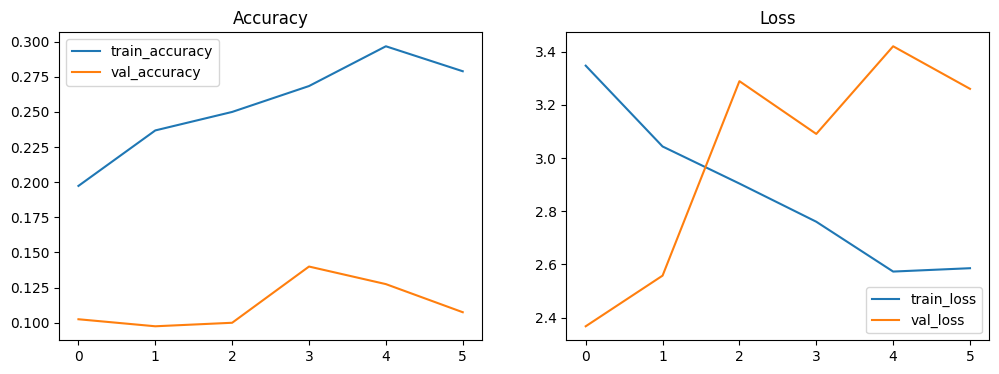

In [ ]:
# Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.model_selection import train_test_split
import pandas as pd

# Set paths
TRAIN_DATASET_PATH = '/content/drive/MyDrive/food-101-tiny/train'
VALID_DATASET_PATH = '/content/drive/MyDrive/food-101-tiny/valid'

# Constants
IMAGE_SIZE = (128, 128)
CLASSES = ['apple_pie', 'bibimbap', 'cannoli', 'edamame', 'falafel', 'french_toast', 'ice_cream', 'ramen', 'sushi', 'tiramisu']

# Data Generators for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET_PATH,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32
)

# Data Generators for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    VALID_DATASET_PATH,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32,
    shuffle=False
)

# Split validation data into validation and test sets
val_files, val_labels = valid_generator.filepaths, valid_generator.labels
val_files_train, val_files_test, val_labels_train, val_labels_test = train_test_split(
    val_files, val_labels, test_size=0.2, stratify=val_labels)

# Create data generators for the new validation and test datasets
new_valid_datagen = ImageDataGenerator(rescale=1./255)
new_test_datagen = ImageDataGenerator(rescale=1./255)

new_valid_generator = new_valid_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files_train, 'class': [CLASSES[label] for label in val_labels_train]}),
    directory=VALID_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32,
    shuffle=True
)

test_generator = new_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files_test, 'class': [CLASSES[label] for label in val_labels_test]}),
    directory=VALID_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32,
    shuffle=False
)

# Build Model
def build_model(conv_filters, kernel_sizes, dense_units, dropout_rate):
    model = Sequential()
    model.add(Conv2D(conv_filters[0], kernel_sizes[0], activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    for filters, kernel_size in zip(conv_filters[1:], kernel_sizes[1:]):
        model.add(Conv2D(filters, kernel_size, activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(CLASSES), activation='softmax'))

    return model

# Compile and Train Model
def compile_and_train_model(model, optimizer, epochs=25, batch_size=32):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for checkpointing and early stopping
    checkpoint = ModelCheckpoint('/content/drive/MyDrive/model_checkpoint.h5', save_best_only=True, monitor='val_loss')
    csv_logger = CSVLogger('/content/drive/MyDrive/training_log.csv', append=True)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=new_valid_generator,
        callbacks=[checkpoint, csv_logger, early_stopping]
    )
    return history

# Train with modified hyperparameters
model = build_model([32, 64, 128, 256], [(3, 3), (3, 3), (3, 3), (3, 3)], 512, 0.6)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
history = compile_and_train_model(model, optimizer, epochs=25, batch_size=32)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate Kappa value
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f'Kappa Score: {kappa:.4f}')

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1520 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.
Found 100 validated image filenames belonging to 10 classes.
Epoch 1/15
48/48 [==============================] - ETA: 0s - loss: 11.8829 - accuracy: 0.1882

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 81s 2s/step - loss: 11.8829 - accuracy: 0.1882 - val_loss: 7.0737 - val_accuracy: 0.0950
Epoch 2/15
48/48 [==============================] - 85s 2s/step - loss: 10.5989 - accuracy: 0.2086 - val_loss: 6.6653 - val_accuracy: 0.1150
Epoch 3/15
48/48 [==============================] - 78s 2s/step - loss: 6.8570 - accuracy: 0.2283 - val_loss: 7.5734 - val_accuracy: 0.1200
Epoch 4/15
48/48 [==============================] - 76s 2s/step - loss: 4.6905 - accuracy: 0.2230 - val_loss: 7.0255 - val_accuracy: 0.1100
Epoch 5/15
48/48 [==============================] - 79s 2s/step - loss: 3.6445 - accuracy: 0.2079 - val_loss: 6.6371 - val_accuracy: 0.1375
Epoch 6/15
48/48 [==============================] - 80s 2s/step - loss: 2.9800 - accuracy: 0.2289 - val_loss: 5.4710 - val_accuracy: 0.1400
Epoch 7/15
48/48 [==============================] - 80s 2s/step - loss: 2.4049 - accuracy: 0.2480 - val_loss: 3.9707 - val_accuracy: 0.1375
Epoch 8/15
48/48 [===========

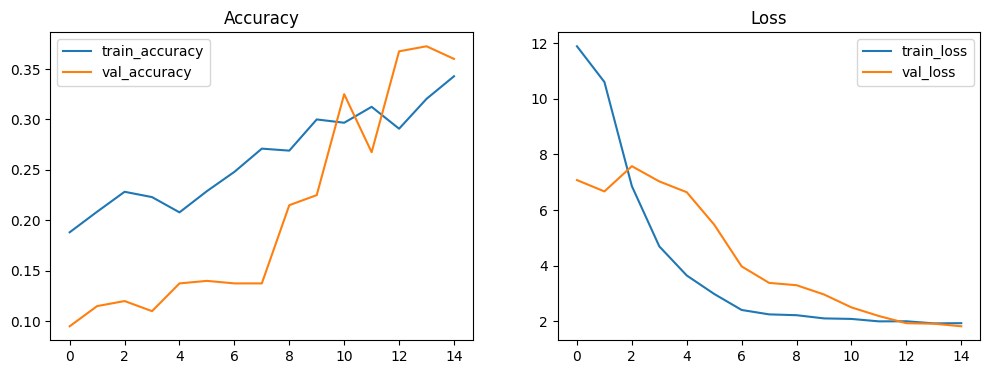

In [ ]:
# Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.model_selection import train_test_split
import pandas as pd

# Set paths
TRAIN_DATASET_PATH = '/content/drive/MyDrive/food-101-tiny/train'
VALID_DATASET_PATH = '/content/drive/MyDrive/food-101-tiny/valid'

# Constants
IMAGE_SIZE = (128, 128)
CLASSES = ['apple_pie', 'bibimbap', 'cannoli', 'edamame', 'falafel', 'french_toast', 'ice_cream', 'ramen', 'sushi', 'tiramisu']

# Data Generators for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET_PATH,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32
)

# Data Generators for validation and test data
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    VALID_DATASET_PATH,
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32,
    shuffle=False
)

# Split validation data into validation and test sets
val_files, val_labels = valid_generator.filepaths, valid_generator.labels
val_files_train, val_files_test, val_labels_train, val_labels_test = train_test_split(
    val_files, val_labels, test_size=0.2, stratify=val_labels)

# Create data generators for the new validation and test datasets
new_valid_datagen = ImageDataGenerator(rescale=1./255)
new_test_datagen = ImageDataGenerator(rescale=1./255)

new_valid_generator = new_valid_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files_train, 'class': [CLASSES[label] for label in val_labels_train]}),
    directory=VALID_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32,
    shuffle=True
)

test_generator = new_test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_files_test, 'class': [CLASSES[label] for label in val_labels_test]}),
    directory=VALID_DATASET_PATH,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    classes=CLASSES,
    batch_size=32,
    shuffle=False
)

# Build Model
def build_model(conv_filters, kernel_sizes, dense_units, dropout_rate):
    model = Sequential()
    model.add(Conv2D(conv_filters[0], kernel_sizes[0], activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    for filters, kernel_size in zip(conv_filters[1:], kernel_sizes[1:]):
        model.add(Conv2D(filters, kernel_size, activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(CLASSES), activation='softmax'))

    return model

# Compile and Train Model
def compile_and_train_model(model, optimizer, epochs=15, batch_size=32):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for checkpointing and early stopping
    checkpoint = ModelCheckpoint('/content/drive/MyDrive/model_checkpoint.h5', save_best_only=True, monitor='val_loss')
    csv_logger = CSVLogger('/content/drive/MyDrive/training_log.csv', append=True)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=new_valid_generator,
        callbacks=[checkpoint, csv_logger, early_stopping]
    )
    return history

# Train with modified hyperparameters
model = build_model([32, 64, 128], [(3, 3), (3, 3), (3, 3)], 512, 0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = compile_and_train_model(model, optimizer, epochs=15, batch_size=32)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate Kappa value
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
kappa = cohen_kappa_score(y_true, y_pred_classes)
print(f'Kappa Score: {kappa:.4f}')

# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.show()
